In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import shap

In [3]:
DATA_PATH="./Vowel_Data/Formant/"

In [4]:
seed=0

In [5]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)
        
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    all_formants['disp(F5-F1)']=all_formants['F5']-all_formants['F1']
    all_formants['disp(F4-F3)']=all_formants['F4']-all_formants['F3']
    all_formants['disp(F5-F3)']=all_formants['F5']-all_formants['F3']
    all_formants['disp(F5-F4)']=all_formants['F5']-all_formants['F4']
    
    X=all_formants.drop(labels=['label'],axis=1).values
    y=all_formants['label'].values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [6]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 190.86it/s]


In [7]:
np.random.seed(seed)

In [ ]:
model_v=Sequential()
#model_v.add(Dense(128, activation='relu', input_shape=(6,)))
#model_v.add(Dense(64, activation='relu'))
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [8]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [9]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 1s 1s/step - loss: 2.0888 - accuracy: 0.1682 - auc: 0.5213 - val_loss: 1.9973 - val_accuracy: 0.2072 - val_auc: 0.5394
Epoch 2/50
1/1 [==============================] - 0s 380ms/step - loss: 1.9990 - accuracy: 0.2044 - auc: 0.5376 - val_loss: 1.9316 - val_accuracy: 0.1860 - val_auc: 0.5644
Epoch 3/50
1/1 [==============================] - 0s 158ms/step - loss: 1.9325 - accuracy: 0.1815 - auc: 0.5630 - val_loss: 1.9036 - val_accuracy: 0.1765 - val_auc: 0.6092
Epoch 4/50
1/1 [==============================] - 0s 182ms/step - loss: 1.9013 - accuracy: 0.1823 - auc: 0.6115 - val_loss: 1.9039 - val_accuracy: 0.2309 - val_auc: 0.6046
Epoch 5/50
1/1 [==============================] - 0s 226ms/step - loss: 1.9065 - accuracy: 0.2330 - auc: 0.6013 - val_loss: 1.9087 - val_accuracy: 0.2164 - val_auc: 0.5978
Epoch 6/50
1/1 [==============================] - 0s 221ms/ste

In [10]:
e=shap.DeepExplainer(model_v,X_test)

In [11]:
shape_values=e.shap_values(X_test)

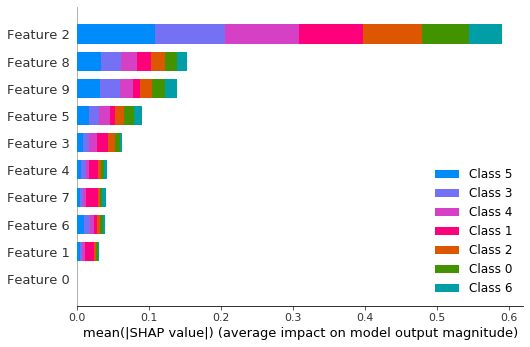

In [15]:
shap.summary_plot(shape_values,X_test)

In [169]:
model_v.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_44 (Dense)             (None, 7)                 119       
Total params: 999
Trainable params: 999
Non-trainable params: 0
_________________________________________________________________


In [170]:
history_dict=history_v.history

loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

auc_v=history_dict['auc']
val_auc_v=history_dict['val_auc']

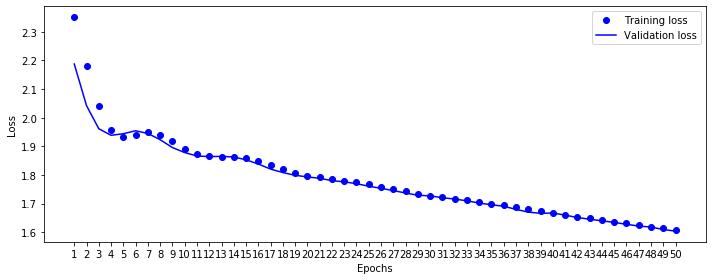

In [171]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'bo',label='Training loss')
plt.plot(epochs,val_loss_v,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

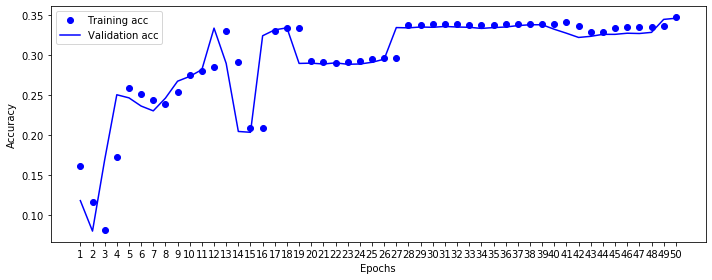

In [172]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

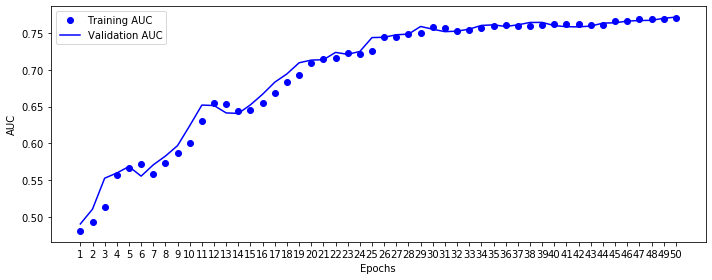

In [173]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'bo',label='Training AUC')
plt.plot(epochs,val_auc_v,'b',label='Validation AUC')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/AUC_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

In [97]:
DATA_PATH="./Word_Data/Formant/"

In [98]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)
        
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    all_formants['disp(F5-F1)']=all_formants['F5']-all_formants['F1']
    all_formants['disp(F4-F3)']=all_formants['F4']-all_formants['F3']
    all_formants['disp(F5-F3)']=all_formants['F5']-all_formants['F3']
    all_formants['disp(F5-F4)']=all_formants['F5']-all_formants['F4']    
    
    X=all_formants.drop(labels=['label'],axis=1).values
    y=all_formants['label'].values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [99]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 330.01it/s]


In [100]:
model_w=Sequential()
#model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
#model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [101]:
model_w.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [102]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 1s 547ms/step - loss: 2.0687 - accuracy: 0.1492 - auc: 0.5154 - val_loss: 1.9982 - val_accuracy: 0.1844 - val_auc: 0.5263
Epoch 2/50
1/1 [==============================] - 0s 141ms/step - loss: 1.9899 - accuracy: 0.1930 - auc: 0.5329 - val_loss: 1.9570 - val_accuracy: 0.2242 - val_auc: 0.5467
Epoch 3/50
1/1 [==============================] - 0s 180ms/step - loss: 1.9487 - accuracy: 0.2294 - auc: 0.5544 - val_loss: 1.9431 - val_accuracy: 0.2476 - val_auc: 0.5537
Epoch 4/50
1/1 [==============================] - 0s 120ms/step - loss: 1.9361 - accuracy: 0.2511 - auc: 0.5598 - val_loss: 1.9334 - val_accuracy: 0.2397 - val_auc: 0.5607
Epoch 5/50
1/1 [==============================] - 0s 97ms/step - loss: 1.9271 - accuracy: 0.2431 - auc: 0.5663 - val_loss: 1.9184 - val_accuracy: 0.2392 - val_auc: 0.5744
Epoch 6/50
1/1 [==============================] - 0s 138ms/step - loss: 1.9128 - accuracy: 0.2415 - auc: 0.5797 - val_loss: 1.9018 - val_accu

In [103]:
history_dict=history_w.history
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

auc_w=history_dict['auc']
val_auc_w=history_dict['val_auc']

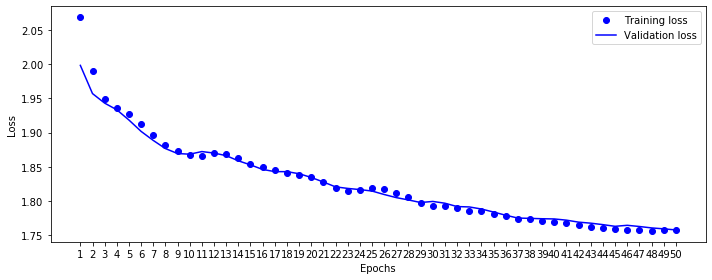

In [104]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_word_'+save_specifier+'.svg',format='svg', dpi=600)

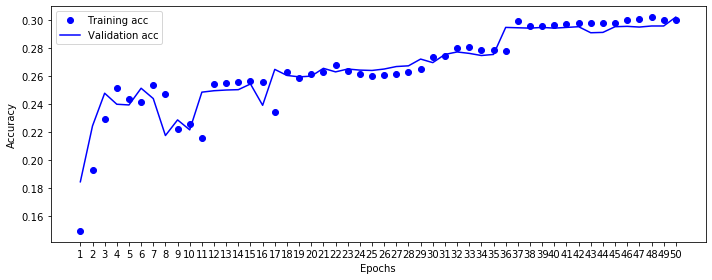

In [105]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_word_'+save_specifier+'.svg',format='svg', dpi=600)

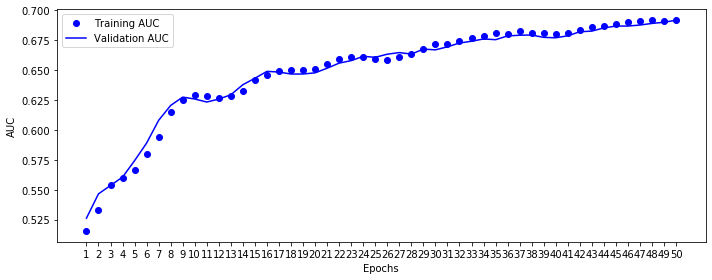

In [106]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_w,'bo',label='Training AUC')
plt.plot(epochs,val_auc_w,'b',label='Validation AUC')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/AUC_word_'+save_specifier+'.svg',format='svg', dpi=600)

In [107]:
#COMPARE

In [108]:
epochs=range(1,len(loss_v)+1)

In [109]:
save_specifier='fromant_disp_32_16_tanh_softmax_adam_0.005_batchfull_adding_input_shape'

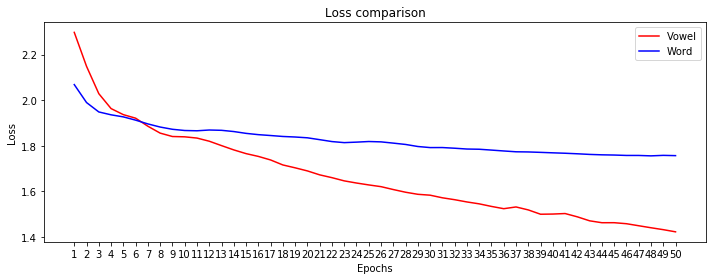

In [110]:
#sns.reset()
#sns.reset_orig()
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_compare_'+save_specifier+'.svg',format='svg',dpi=600)
#plt.savefig('./Result/New_without_CNN/loss_compare_'+save_specifier+'.eps',format='eps',dpi=600)

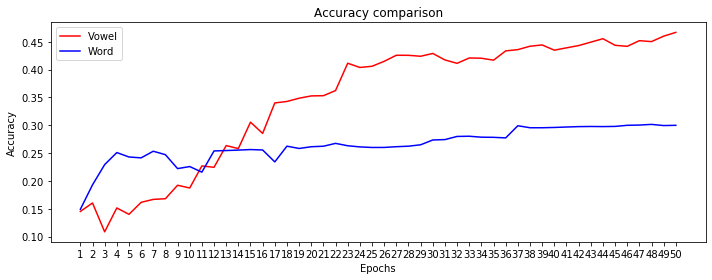

In [111]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_compate_'+save_specifier+'.svg',format='svg',dpi=600)
#plt.savefig('./Result/New_without_CNN/accuracy_compate_'+save_specifier+'.eps',format='eps',dpi=600)

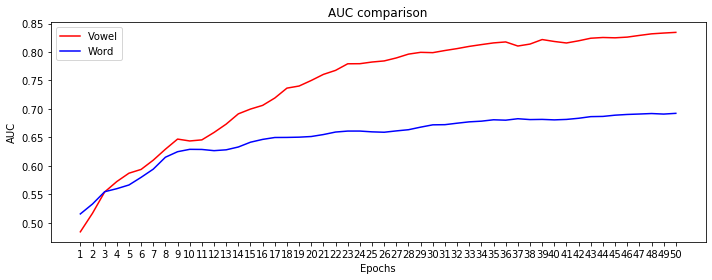

In [112]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'r',label='Vowel')
plt.plot(epochs,auc_w,'b',label='Word')
plt.title('AUC comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/AUC_compate_'+save_specifier+'.svg',format='svg',dpi=600)
#plt.savefig('./Result/New_without_CNN/AUC_compate_'+save_specifier+'.eps',format='eps',dpi=600)

In [39]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'acc_v':acc_v,
                      'val_acc_v':val_acc_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'acc_w':acc_w,
                      'val_acc_w':val_acc_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./Result/New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [144]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.510234,1.498732,0.366437,0.370279,0.796772,0.800146,1.708708,1.714930,0.303956,0.299898,0.720853,0.715563
46,1.504479,1.498546,0.365201,0.367102,0.797813,0.798793,1.707437,1.713586,0.305353,0.300660,0.721409,0.716229
47,1.500465,1.493217,0.364848,0.376633,0.798146,0.801928,1.706840,1.713536,0.305924,0.298121,0.721904,0.715366
48,1.497878,1.487364,0.368114,0.381221,0.799064,0.803229,1.704514,1.714414,0.304591,0.297613,0.721866,0.713816
49,1.493867,1.477454,0.372881,0.384045,0.799755,0.805838,1.703115,1.715560,0.304019,0.295328,0.721080,0.712323


In [40]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.411883,1.405710,0.447034,0.461701,0.833349,0.836040,1.781247,1.795952,0.276208,0.262062,0.681543,0.670234
46,1.397944,1.405708,0.465660,0.461701,0.838839,0.836425,1.781183,1.794109,0.273224,0.264093,0.679729,0.671856
47,1.398288,1.398337,0.465749,0.469820,0.838970,0.838291,1.782951,1.789811,0.272017,0.279584,0.678212,0.675529
48,1.396289,1.386209,0.470251,0.492411,0.839035,0.842212,1.780074,1.782680,0.288463,0.283647,0.680309,0.680218
49,1.383023,1.377770,0.486405,0.498412,0.843179,0.843809,1.774793,1.775333,0.290939,0.297359,0.684268,0.684437


In [124]:
np.random.seed(seed)

In [126]:
np.random.rand()

0.7151893663724195